In [1]:
import os 
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

In [3]:
class MediaPostState(TypedDict):
    topic:str
    post:str
    evaluation:str
    feedback:str
    max_iteration:int

In [4]:
class Evaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [5]:
generation_llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.7
)

evaluation_llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.7
)

optimize_llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.7
)

In [6]:
structure_evaluation_llm = evaluation_llm.with_structured_output(Evaluation)

In [7]:
generation_prompt = ChatPromptTemplate.from_template(
    """
Write a short, original, and hilarious tweet on the topic: {topic}.

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
"""
)

evaluation_prompt = ChatPromptTemplate.from_template(
    """You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on 
    humor, originality, virality, and tweet format.
    
    Evaluate the following tweet:

Tweet: {tweet}

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
"""
)

optimize_prompt = ChatPromptTemplate.from_template(
    """You punch up tweets for virality and humor based on given feedback.
    
    Improve the tweet based on this feedback:
{feedback}

Topic: {topic}
Original Tweet:
{tweet}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
    
    """
)

In [8]:
generation_chain = generation_prompt | generation_llm
evaluation_chain = evaluation_prompt | structure_evaluation_llm
optimize_chain = optimize_prompt | optimize_llm

In [9]:
def generate_post(state:MediaPostState)->MediaPostState:
    state["post"] = generation_chain.invoke({"topic":state["topic"]})
    return state


def provide_evaluation(state:MediaPostState)->MediaPostState:
    answer = evaluation_chain.invoke({"tweet":state["post"]})
    return {"evaluation": answer.evaluation, "feedback":answer.feedback}

def optimize_tweet(state:MediaPostState)->MediaPostState:
    state["post"] = optimize_chain.invoke({"feedback":state["feedback"], "topic":state["topic"], "tweet":state["post"]})
    state["max_iteration"] = state["max_iteration"] + 1
    return state

In [10]:
def condition_check(state:MediaPostState):
    if state["evaluation"] == "approved" or state["max_iteration"] == 5:
        return "approved"
    else:
        return "needs_improvement"

In [11]:
graph = StateGraph(MediaPostState)

graph.add_node("generate_post", generate_post)
graph.add_node("provide_evaluation", provide_evaluation)
graph.add_node("optimize_tweet", optimize_tweet)

graph.add_edge(START,"generate_post")
graph.add_edge("generate_post", "provide_evaluation")
graph.add_conditional_edges("provide_evaluation", condition_check, {"approved":END, "needs_improvement":"optimize_tweet"})
graph.add_edge("optimize_tweet", "provide_evaluation")

workflow = graph.compile()

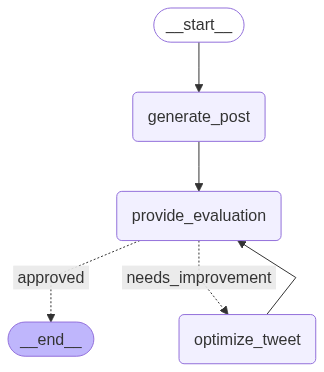

In [12]:
workflow

In [13]:
response = workflow.invoke({"topic": "Trending in AI field", "max_iteration": 0})
response

{'topic': 'Trending in AI field',
 'post': AIMessage(content='Here are a few options for a revised tweet, aiming for virality and humor:\n\n**Option 1 (Sarcastic & Relatable):**\n\n> My AI-generated dating profile says I enjoy "debugging my emotions."  Yeah, swipe left. Send chocolate. #AIDating #AIfail #singledumb\n\n\n**Option 2 (Absurdist Humor):**\n\n> AI wrote my dating profile.  My ideal date?  A 1TB hard drive.  Someone send help (and maybe a backup). #AIgonewild #robotlove #datingdisaster\n\n\n**Option 3 (Self-Deprecating & Funny):**\n\n> Asked AI to write my dating profile. It suggested my "greatest strength is processing large datasets."  Guess I\'ll keep swiping. #AIromance #foreveralone #datingsucks\n\n\n**Option 4 (More concise and punchy):**\n\n> AI dating profile: "Passionate about binary code."  My dating life: 01000010 01101111 01101100 01101100 01101111. #AIProblems #DatingFail\n\n\nThese options improve on the original by:\n\n* **Stronger punchlines:**  They offer mo